# Stacking
Stack the data to explore the average properties of the undetected source population.

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import QTable
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord

from scipy.constants import c
from scipy.stats import norm, trim_mean, bootstrap, ks_2samp
from scipy.optimize import curve_fit
#from scipy.special import erf, erfinv

import matplotlib.pyplot as plt

## Define a Cosmology

In [2]:
# Planck+18 cosmology
from astropy.cosmology import Planck18 as cosmo
print(cosmo.H0, cosmo.Tcmb, cosmo.Om0)

# custom cosmology
#cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

67.66 km / (Mpc s) <bound method FLRW.Tcmb of FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)> 0.30966


## Load Data

In [3]:
# load data from tables
table1 = np.loadtxt("../tables/table1.csv", delimiter=",", dtype=str).T
table2 = np.loadtxt("../tables/table2.csv", delimiter=",", dtype=str).T

obsname = table1[0]
rms, mad, x_mean, y_mean, x_stddev, y_stddev, amplitude, amplitude_fixed, blanks, fluxint, fluxsum, fluxpeak, blankpeak, snr_peak, snr_amp, peak_flux, peak_flux_dist, solint, flagstat_avg = table1[1:].astype(float)
z, freq, _, mad, ul, Mo, allwise_AB, allwise_err, spitzer_AB, spitzer_AB_err, Lsgn, log_L_nu, log_L_peak, log_L_peak_err, log_L_ul, log_Lo, log_Lo_err, R, Rerr, Rul = table2[1:].astype(float)

# specific luminosity
L_nu = Lsgn * 10**log_L_nu * 1e-26

# rest-frame flux density at 1.6 GHz
f0 = (1 + z) * 1.6e9

# luminosity distance
dl = cosmo.luminosity_distance(z).to("m").value

# solar luminosity
Lsol = 3.828e26

# assumed radio spectral index
alpha = -0.75

# compute log luminosity
Lsgn = np.sign(fluxpeak)
log_L_peak = np.log10(4 * np.pi * dl**2 * 1e-26 * (5e9 / f0)**-0.75 * np.abs(fluxpeak) / (1+z) / 1e6)

# define two redshift bins
idx_low = z < 6.150
idx_high = z >= 6.150

# radio loudness
R = 10 ** (log_L_peak - np.log10(Lsol / 5e9) - log_Lo) * (c / 4.4e-7 / 5e9)
R *= Lsgn

# print median noise RMS and its standard deviation
print(f"Median MAD: {np.median(mad)}, STD of MAD: {np.std(mad)}")

Median MAD: 36.25, STD of MAD: 6.398493770980955


## Define Functions

In [4]:
def get_target_pixel(hdu, target_coord_str):
    """Get the pixel number corresponding to the target coordinates

    Parameters
    ----------
    hdu : object
        FITS Header Data Unit as returned by astropy.fits.open()
    target_coord_str : str
        Coordinate string that can be accepted by astropy.coordinates.Skycoord()
        in units of hours (RA) and degrees (Dec)

    Returns
    -------
    tuple of floats
        target pixel
    """
    
    # Extract the image data and header
    image_header = hdu.header

    # Create a WCS object from the FITS header
    wcs = WCS(image_header)

    # Convert the target coordinate to SkyCoord object
    target_coord = SkyCoord(target_coord_str, unit=(u.hourangle, u.deg))

    # Convert the target coordinate to pixel coordinates
    target_pixel = wcs.all_world2pix(target_coord.ra.deg, target_coord.dec.deg, 0, 0, 1)
    
    # Round the pixel coordinates to the nearest integer
    target_pixel = np.round(target_pixel).astype(int) - np.array([1, 1, 1, 1])

    return target_pixel

def get_cutout(data, cutout, pc):
    """Get a cutour image of a given size at a given pixel coordinate

    Parameters
    ----------
    data : ndarray
        2D numpy data array
    cutout : int
        cutout size in number of pixels
    pc : tuple of ints
        pixel coordinates of cutout centre

    Returns
    -------
    ndarray
        2D numpy data array cutout
    """
    N = data.shape[0]

    nstart0 = max(pc[0] - cutout // 2, 0)
    nend0 = min(pc[0] + cutout // 2 + 1, N)
    nstart1 = max(pc[1] - cutout // 2, 0)
    nend1 = min(pc[1] + cutout // 2 + 1, N)

    return data[nstart0:nend0, nstart1:nend1]

def gaussian_2d(xy, amplitude, x0, y0, sigmin, sigmaj, theta):
    """2D Guassian function

    Parameters
    ----------
    xy : tuple of ndarrays
        x and y values (x, y) at which to evaluate 2D Gaussian
    amplitude : float
        amplitude of Gaussian
    xo : float
        x-mean of Gaussian
    yo : _type_
        y-mean of Gaussian
    sigmin : float
        x standard deviation of Gaussian
    sigmaj : float
        y standard deviation of Gaussian
    theta : float
        position angle of 2D Gaussian

    Returns
    -------
    ndarray
        Values of 2D Gaussian evaluated at xy-coordinates.
    """
    x, y = xy
    x0 = float(x0)
    y0 = float(y0)
    a = (np.cos(theta)**2) / (2 * sigmin**2) + (np.sin(theta)**2) / (2 * sigmaj**2)
    b = -(np.sin(2 * theta)) / (4 * sigmin**2) + (np.sin(2 * theta)) / (4 * sigmaj**2)
    c = (np.sin(theta)**2) / (2 * sigmin**2) + (np.cos(theta)**2) / (2 * sigmaj**2)
    g = amplitude * np.exp(- (a * ((x - x0)**2) + 2 * b * (x - x0) * (y - y0) + c * ((y - y0)**2)))

    return g.ravel()

def gauss_fit_2d(xy, data, bounds):
    """Fit a 2D Gaussian to data

    Parameters
    ----------
    xy : tuple
        (X, Y) data
    data : ndarray
        2D data array
    bounds : tuple
        bounds of (amplitude, x-mean, y-mean, x standard deviation, y standard deviation and position angle)
        given as a tuple of lists of 2 floats ([lower, upper], ...)

    Returns
    -------
    tuple
        best-fit parameters as returned by scipy.optimize.curve_fit()
    """
    # Perform the Gaussian fit
    popt, pcov = curve_fit(gaussian_2d, xy, data.ravel(), p0=(np.max(data), 0, 0, 0, 5, 5), bounds=bounds)

    # Extract the fitted parameters
    return popt

## Load Images

In [5]:
# image cell size
cell = 0.3 # arcsec

# define image file wildcards
imdir = "/rds/user/pmk46/hpc-work/19A-056/final/images/*.fits"
images = []

# load quasar catalogue table
qso_catalog = QTable.read('../tables/Quasar_catalog_Banados+16_Matsuoka+19a_Matsuoka+19b_Wang+18_Wang+19_Reed+19_Yang+20.txt', format='ascii')

for name in table2[0]:
    catalog_name = list(name)
    catalog_name[3] = "_"
    catalog_name = "".join(catalog_name)

    # read QSO catalogue
    row = qso_catalog[qso_catalog["QSO-Name"] ==  catalog_name]
    ra = row["RA"].value[0]
    dec = row["Dec"].value[0]

    # read image
    imfits = f"/rds/user/pmk46/hpc-work/19A-056/final/images/{name}-res.im-MFS-image.fits"
    hdu = fits.open(imfits)[0]
    pc = get_target_pixel(hdu, f"{ra} {dec}")[[0, 1]]
    image_data = hdu.data[0, 0]

    # get image cutout
    if not np.isnan(image_data).any():
        im = get_cutout(image_data, 41, pc)
        images.append(im)
    else:
        print(f"NaN in {imfits}!")

## Plot

### Stack Histograms

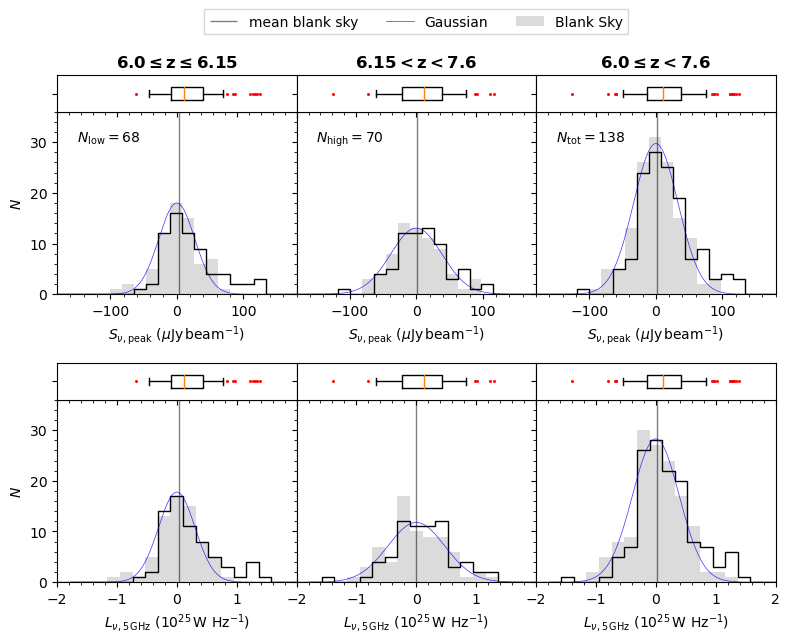

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6.5), sharey=True)
x = np.linspace(-2e2, 2e2, 1000)

nbins = 18
bins = np.arange(-1e3, 1e3, nbins)

# low z
mad = 1.4826 * np.nanmedian(np.abs(blankpeak[idx_low] - np.nanmedian(blankpeak[idx_low])))
y = norm.pdf(x, 0, mad) * sum(idx_low) * nbins

# plot histogram
hist_centre, binc = np.histogram(fluxpeak[idx_low], bins, density=False)
hist_blanks, binc = np.histogram(blankpeak[idx_low], bins, density=False)
binc = 0.5 * (binc[1:] + binc[1:])

# format
#ax[0, 0].vlines(np.nanmedian(fluxpeak[idx_low]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="dotted", color="red", label="median")
ax[0, 0].vlines(np.nanmean(blankpeak[idx_low]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="-", color="k", alpha=0.5, label="mean blank sky")
ax[0, 0].plot(x, y, linewidth=.5, alpha=.8, color="b", label="Gaussian")
ax[0, 0].step(binc, hist_centre, color="k", linewidth=1, label="Centre Pixel")
ax[0, 0].fill_between(binc, hist_blanks, color="lightgray", step="pre", linewidth=0, alpha=0.8, label="Blank Sky")
ax[0, 0].set_xlim([-1.8e2, 1.8e2])
ax[0, 0].set_ylim([0.0, 18.0])
ax[0, 0].set_xlabel(r"$S_{\nu,\mathrm{peak}}$ $(\mu\mathrm{Jy\,beam}^{-1})$")
ax[0, 0].set_ylabel(r"$N$")
ax[0, 0].text(-150, 30, rf"$N_\mathrm{{low}}={np.sum(idx_low)}$")
ax[0, 0].minorticks_on()

# high z
mad = 1.4826 * np.nanmedian(np.abs(blankpeak[idx_high] - np.nanmedian(blankpeak[idx_high])))
y = norm.pdf(x, 0, mad) * sum(idx_high) * nbins

# plot histogram
hist_centre, binc = np.histogram(fluxpeak[idx_high], bins, density=False)
hist_blanks, binc = np.histogram(blankpeak[idx_high], bins, density=False)
binc = 0.5 * (binc[1:] + binc[1:])

# format
#ax[0, 1].vlines(np.nanmedian(fluxpeak[idx_high]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="dotted", color="red", label="median")
ax[0, 1].vlines(np.nanmean(blankpeak[idx_high]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="-", color="k", alpha=0.5, label="mean blank sky")
ax[0, 1].plot(x, y, linewidth=.5, alpha=.8, color="b", label="Gaussian")
ax[0, 1].step(binc, hist_centre, color="k", linewidth=1)
ax[0, 1].fill_between(binc, hist_blanks, color="lightgray", step="pre", linewidth=0, alpha=0.8, label="Blank Sky")
ax[0, 1].set_xlim([-1.8e2, 1.8e2])
ax[0, 1].set_ylim([0.0, 18.0])
ax[0, 1].set_xlabel(r"$S_{\nu,\mathrm{peak}}$ $(\mu\mathrm{Jy\,beam}^{-1})$")
ax[0, 1].text(-150, 30, rf"$N_\mathrm{{high}}={np.sum(idx_high)}$")
ax[0, 1].minorticks_on()

# all z
mad = 1.4826 * np.nanmedian(np.abs(blankpeak - np.nanmedian(blankpeak)))

y = norm.pdf(x, 0, mad) * 138 * nbins

# plot histogram
hist_centre, binc = np.histogram(fluxpeak, bins, density=False)
hist_blanks, binc = np.histogram(blankpeak, bins, density=False)
binc = 0.5 * (binc[1:] + binc[1:])

# format
#ax[0, 2].vlines(np.nanmedian(fluxpeak), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="dotted", color="red", label="median")
ax[0, 2].vlines(np.nanmean(blankpeak), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="-", color="k", alpha=0.5, label="mean blank sky")
ax[0, 2].plot(x, y, linewidth=.5, alpha=.8, color="b", label="Gaussian")
ax[0, 2].step(binc, hist_centre, color="k", linewidth=1)
ax[0, 2].fill_between(binc, hist_blanks, color="lightgray", step="pre", linewidth=0, alpha=0.8)
ax[0, 2].set_xlim([-1.8e2, 1.8e2])
ax[0, 2].set_ylim([0.0, 36.0])
ax[0, 2].set_xlabel(r"$S_{\nu,\mathrm{peak}}$ $(\mu\mathrm{Jy\,beam}^{-1})$")
ax[0, 2].text(-150, 30, rf"$N_\mathrm{{tot}}={len(blankpeak)}$")
ax[0, 2].minorticks_on()

ax[0, 0].set_title(r"$\bf{6.0 \leq z \leq 6.15}$", weight='bold', fontsize=12)
ax[0, 1].set_title(r"$\bf{6.15 < z < 7.6}$", weight='bold', fontsize=12)
ax[0, 2].set_title(r"$\bf{6.0 \leq z < 7.6}$", weight='bold', fontsize=12)

x = np.linspace(-2, 2, 1000)

nbins = 20
bins = np.linspace(-2, 2, nbins)

L_blankpeak = 4 * np.pi * dl**2 * 1e-26 * (5e9 / f0)**alpha * blankpeak * 1e-6 / (1+z) / 1e25

# low z
mad = 1.4826 * np.nanmedian(np.abs(L_blankpeak[idx_low] - np.nanmedian(L_blankpeak[idx_low])))
y = norm.pdf(x, 0, mad) * sum(idx_low) * (np.max(bins)-np.min(bins)) / nbins

hist_centre, binc = np.histogram((Lsgn*10**log_L_peak*1e-25)[idx_low], bins, density=False)
hist_blanks, binc = np.histogram(L_blankpeak[idx_low], bins, density=False)
binc = 0.5 * (binc[1:] + binc[1:])

# format
#ax[1, 0].vlines(np.nanmedian((Lsgn*10**log_L_peak*1e-25)[idx_low]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="dotted", color="red", label="median")
ax[1, 0].vlines(np.nanmean(L_blankpeak[idx_low]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="-", color="k", alpha=0.5, label="mean blank sky")
ax[1, 0].step(binc, hist_centre, color="k", linewidth=1)
ax[1, 0].plot(x, y, linewidth=.5, alpha=.8, color="b", label="Gaussian")
ax[1, 0].fill_between(binc, hist_blanks, color="lightgray", step="pre", linewidth=0, alpha=0.8)
ax[1, 0].set_xlim([-2, 2])
ax[1, 0].set_ylim([0.0, 18.0])
ax[1, 0].set_xlabel(r"$L_{\nu,\mathrm{5\,GHz}}$ $\left(10^{25}\,\mathrm{W~Hz}^{-1}\right)$")
ax[1, 0].set_ylabel(r"$N$")
ax[1, 0].set_xticks([-2, -1, 0, 1])
ax[1, 0].minorticks_on()

# high z
mad = 1.4826 * np.nanmedian(np.abs(L_blankpeak[idx_high] - np.nanmedian(L_blankpeak[idx_high])))
y = norm.pdf(x, 0, mad) * sum(idx_high) * (np.max(bins)-np.min(bins)) / nbins

# plot histogram
hist_centre, binc = np.histogram((Lsgn*10**log_L_peak*1e-25)[idx_high], bins, density=False)
hist_blanks, binc = np.histogram(L_blankpeak[idx_high], bins, density=False)
binc = 0.5 * (binc[1:] + binc[1:])

# format
#ax[1, 1].vlines(np.nanmedian((Lsgn*10**log_L_peak*1e-25)[idx_high]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="dotted", color="red", label="median")
ax[1, 1].vlines(np.nanmean(L_blankpeak[idx_high]), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="-", color="k", alpha=0.5, label="mean blank sky")
ax[1, 1].step(binc, hist_centre, color="k", linewidth=1)
ax[1, 1].plot(x, y, linewidth=.5, alpha=.8, color="b", label="Gaussian")
ax[1, 1].fill_between(binc, hist_blanks, color="lightgray", step="pre", linewidth=0, alpha=0.8)
ax[1, 1].set_xlim([-2, 2])
ax[1, 1].set_ylim([0.0, 18.0])
ax[1, 1].set_xlabel(r"$L_{\nu,\mathrm{5\,GHz}}$ $\left(10^{25}\,\mathrm{W~Hz}^{-1}\right)$")
ax[1, 1].set_xticks([-2, -1, 0, 1])
ax[1, 1].minorticks_on()

# all z
mad = 1.4826 * np.nanmedian(np.abs(L_blankpeak - np.nanmedian(L_blankpeak)))
y = norm.pdf(x, 0, mad) * 138 * (np.max(bins)-np.min(bins)) / nbins

# plot histogram
hist_centre, binc = np.histogram((Lsgn*10**log_L_peak*1e-25), bins, density=False)
hist_blanks, binc = np.histogram(L_blankpeak, bins, density=False)
binc = 0.5 * (binc[1:] + binc[1:])

# format
#ax[1, 2].vlines(np.nanmedian((Lsgn*10**log_L_peak*1e-25)), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="dotted", color="red", label="median")
ax[1, 2].vlines(np.nanmean(L_blankpeak), 0, 4 * np.max(hist_centre), linewidth=1, linestyle="-", color="k", alpha=0.5, label="mean blank sky")
ax[1, 2].step(binc, hist_centre, color="k", linewidth=1)
ax[1, 2].plot(x, y, linewidth=.5, alpha=.8, color="b", label="Gaussian")
ax[1, 2].fill_between(binc, hist_blanks, color="lightgray", step="pre", linewidth=0, alpha=0.8)
ax[1, 2].set_xlim([-2, 2])
ax[1, 2].set_ylim([0.0, 36.0])
ax[1, 2].set_xlabel(r"$L_{\nu,\mathrm{5\,GHz}}$ $\left(10^{25}\,\mathrm{W~Hz}^{-1}\right)$")
ax[1, 2].set_xticks([-2, -1, 0, 1, 2])
ax[1, 2].minorticks_on()

# plot box whisker plots
flierprops = dict(marker='.', markerfacecolor='r', markersize=1)

ins00 = ax[0, 0].inset_axes([0.0, 1, 1, 0.2])
ins00.boxplot((Lsgn*10**log_L_peak*1e-25)[idx_low], 0, 'rs', 0, 0.75, flierprops=flierprops)
ins00.set_xlim([-2, 2])
ins00.set_ylim([0.8, 1.2])
ins00.minorticks_on()
ins00.xaxis.set_major_formatter(plt.NullFormatter())
ins00.yaxis.set_major_formatter(plt.NullFormatter())

ins01 = ax[0, 1].inset_axes([0.0, 1, 1, 0.2])
ins01.boxplot((Lsgn*10**log_L_peak*1e-25)[idx_high], 0, 'rs', 0, 0.75, flierprops=flierprops)
ins01.set_xlim([-2, 2])
ins01.set_ylim([0.8, 1.2])
ins01.minorticks_on()
ins01.xaxis.set_major_formatter(plt.NullFormatter())
ins01.yaxis.set_major_formatter(plt.NullFormatter())

ins02 = ax[0, 2].inset_axes([0.0, 1, 1, 0.2])
ins02.boxplot((Lsgn*10**log_L_peak*1e-25), 0, 'rs', 0, 0.75, flierprops=flierprops)
ins02.set_xlim([-2, 2])
ins02.set_ylim([0.8, 1.2])
ins02.minorticks_on()
ins02.xaxis.set_major_formatter(plt.NullFormatter())
ins02.yaxis.set_major_formatter(plt.NullFormatter())

ins10 = ax[1, 0].inset_axes([0.0, 1, 1, 0.2])
ins10.boxplot((Lsgn*10**log_L_peak*1e-25)[idx_low], 0, 'rs', 0, 0.75, flierprops=flierprops)
ins10.set_xlim([-2, 2])
ins10.set_ylim([0.8, 1.2])
ins10.minorticks_on()
ins10.xaxis.set_major_formatter(plt.NullFormatter())
ins10.yaxis.set_major_formatter(plt.NullFormatter())

ins11 = ax[1, 1].inset_axes([0.0, 1, 1, 0.2])
ins11.boxplot((Lsgn*10**log_L_peak*1e-25)[idx_high], 0, 'rs', 0, 0.75, flierprops=flierprops)
ins11.set_xlim([-2, 2])
ins11.set_ylim([0.8, 1.2])
ins11.minorticks_on()
ins11.xaxis.set_major_formatter(plt.NullFormatter())
ins11.yaxis.set_major_formatter(plt.NullFormatter())

ins12 = ax[1, 2].inset_axes([0.0, 1, 1, 0.2])
ins12.boxplot((Lsgn*10**log_L_peak*1e-25), 0, 'rs', 0, 0.75, flierprops=flierprops)
ins12.set_xlim([-2, 2])
ins12.set_ylim([0.8, 1.2])
ins12.minorticks_on()
ins12.xaxis.set_major_formatter(plt.NullFormatter())
ins12.yaxis.set_major_formatter(plt.NullFormatter())

plt.tight_layout()

fig.subplots_adjust(wspace=0.0, top=0.825)

ax[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.6), fancybox=False, shadow=False, ncol=5)

plt.savefig("../../plots/stacking.pdf", dpi=600)

### Statistical Tests

In [7]:
# print redshift bin centres
print(f"z-low: {np.median(z[idx_low])}, z-high: {np.median(z[idx_high])}, all-z: {np.median(z)}")

print("z-low:", ks_2samp(blankpeak[idx_low], fluxpeak[idx_low], alternative='two-sided', method='auto'))
print("z-high:", ks_2samp(blankpeak[idx_high], fluxpeak[idx_high], alternative='two-sided', method='auto'))
print("all-z:", ks_2samp(blankpeak, fluxpeak, alternative='two-sided', method='auto'))

z-low: 6.0625, z-high: 6.3726, all-z: 6.15
z-low: KstestResult(statistic=0.19117647058823528, pvalue=0.1670486895246451, statistic_location=18.852, statistic_sign=1)
z-high: KstestResult(statistic=0.14285714285714285, pvalue=0.47553139382153636, statistic_location=32.166, statistic_sign=1)
all-z: KstestResult(statistic=0.13768115942028986, pvalue=0.1463241040404268, statistic_location=23.7, statistic_sign=1)


### Luminosity Stack Images

In [8]:
# assumed radio spectral index
alpha = -0.75

# luminosity distance
dl = cosmo.luminosity_distance(z).to("m").value

# compute luminosity and radio loudness "images"
L_images = np.swapaxes(4 * np.pi * dl**2 * 1e-26 * (5e9 / f0)**alpha * np.swapaxes(images, 0, -1) / (1+z), -1, 0)
R_images = np.swapaxes((np.swapaxes(L_images, 0, -1) / Lsol / 10**log_Lo) * (c / 4.4e-7), -1, 0)

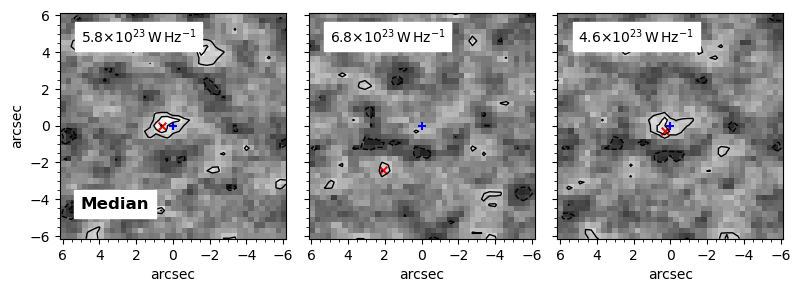

In [9]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3.5))

images = np.array(images)

# low z
median_im = np.nanmedian(L_images[idx_low], axis=0)
mean_im = trim_mean(L_images[idx_low], 0.1, axis=0)
median_mad = 1.4826 * np.nanmedian(np.abs(median_im - np.nanmedian(median_im)))
mean_mad = 1.4826 * np.nanmedian(np.abs(mean_im - np.nanmedian(mean_im)))

N = median_im.shape[0]

mad = median_mad
im = ax[0].imshow(median_im, cmap='gray', origin='lower', vmin=-4*mad, vmax=4*mad, extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

# Add contours to the image
contours_levels = [-5*mad, -4*mad, -3*mad, -2*mad, 2*mad, 3*mad, 4*mad, 5*mad] 

contours = ax[0].contour(median_im, levels=contours_levels, linestyles=None, linewidths=1, negative_linestyles="dashed", colors="k", extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

max_x, max_y = np.unravel_index(np.argmax(median_im), median_im.shape)

ax[0].scatter(0, 0, marker='+', color='b', s=30)
ax[0].scatter((max_y-N//2)*0.3, (max_x-N//2)*0.3, marker='x', color='r', s=30)
ax[0].text(5, 4.5, rf"{(mad*1e-23).round(1)}$\times 10^{{23}}\,$W$\,$Hz$^{{-1}}$", backgroundcolor="white")

# Add labels and title
ax[0].set_ylabel('arcsec')
ax[0].minorticks_on()

# high z
median_im = np.nanmedian(L_images[idx_high], axis=0)
mean_im = trim_mean(L_images[idx_high], 0.1, axis=0)
median_mad = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))
mean_mad = 1.4826 * np.median(np.abs(mean_im - np.median(mean_im)))

N = median_im.shape[1]

mad = median_mad
im = ax[1].imshow(median_im, cmap='gray', origin='lower', vmin=-4*mad, vmax=4*mad, extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

# Add contours to the image
contours_levels = [-5*mad, -4*mad, -3*mad, -2*mad, 2*mad, 3*mad, 4*mad, 5*mad] 

contours = ax[1].contour(median_im, levels=contours_levels, linestyles=None, linewidths=1, negative_linestyles="dashed", colors="k", extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

max_x, max_y = np.unravel_index(np.argmax(median_im), median_im.shape)

ax[1].scatter(0, 0, marker='+', color='b', s=30)
ax[1].scatter((max_y-N//2)*0.3, (max_x-N//2)*0.3, marker='x', color='r', s=30)
ax[1].text(5, 4.5, rf"{(mad*1e-23).round(1)}$\times 10^{{23}}\,$W$\,$Hz$^{{-1}}$", backgroundcolor="white")

# Add labels and title
ax[1].minorticks_on()

# all z

median_im = np.nanmedian(L_images, axis=0)
mean_im = trim_mean(L_images, 0.1, axis=0)
median_mad = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))
mean_mad = 1.4826 * np.median(np.abs(mean_im - np.median(mean_im)))

N = median_im.shape[1]

mad = median_mad
im = ax[2].imshow(median_im, cmap='gray', origin='lower', vmin=-4*mad, vmax=4*mad, extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

# Add contours to the image
contours_levels = [-5*mad, -4*mad, -3*mad, -2*mad, 2*mad, 3*mad, 4*mad, 5*mad] 

contours = ax[2].contour(median_im, levels=contours_levels, linestyles=None, linewidths=1, negative_linestyles="dashed", colors="k", extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

max_x, max_y = np.unravel_index(np.argmax(median_im), median_im.shape)

ax[2].scatter(0, 0, marker='+', color='b', s=30)
ax[2].scatter((max_y-N//2)*0.3, (max_x-N//2)*0.3, marker='x', color='r', s=30)
ax[2].text(5, 4.5, rf"{(mad*1e-23).round(1)}$\times 10^{{23}}\,$W$\,$Hz$^{{-1}}$", backgroundcolor="white")

# Add labels and title
ax[2].minorticks_on()

plt.setp(ax, xticks=np.arange(-6, 8, 2))

ax[0].text(5, -4.5, rf"Median", backgroundcolor="white", weight='bold', fontsize=12)

ax[0].set_xlabel('arcsec')
ax[1].set_xlabel('arcsec')
ax[2].set_xlabel('arcsec')

plt.tight_layout()
plt.gca().invert_xaxis()
fig.subplots_adjust(wspace=0.1)

# Show the plot
#plt.savefig("../../plots/avg_im.pdf", dpi=600)

### Flux Density Stack Images

[-26.1511 -20.9209 -15.6906 -10.4604  10.4604  15.6906  20.9209  26.1511]
[-26.9387 -21.551  -16.1632 -10.7755  10.7755  16.1632  21.551   26.9387]
[-19.5532 -15.6425 -11.7319  -7.8213   7.8213  11.7319  15.6425  19.5532]


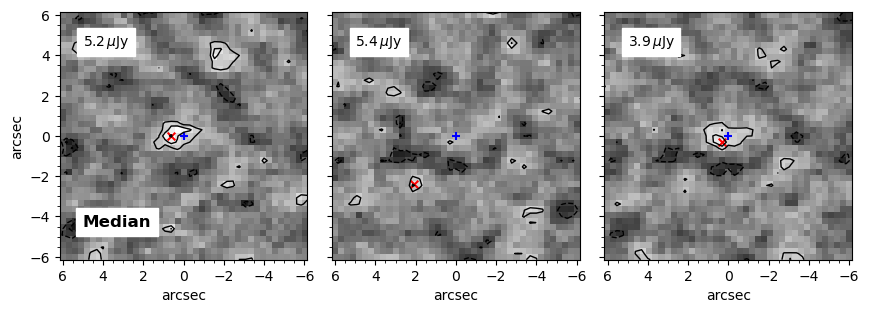

In [10]:
# Create a figure and axes
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9, 3.5))

images = np.array(images)

# low z
median_im = np.nanmedian(images[idx_low], axis=0)
mean_im = trim_mean(images[idx_low], 0.1, axis=0)
median_mad = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))
mean_mad = 1.4826 * np.median(np.abs(mean_im - np.median(mean_im)))

N = median_im.shape[0]

mad = median_mad
im = ax[0].imshow(median_im, cmap='gray', origin='lower', vmin=-4*mad, vmax=4*mad, extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

# Add contours to the image
contours_levels = [-5*mad, -4*mad, -3*mad, -2*mad, 2*mad, 3*mad, 4*mad, 5*mad] 
print((np.array(contours_levels)*1e6).round(4))

contours = ax[0].contour(median_im, levels=contours_levels, linestyles=None, linewidths=1, negative_linestyles="dashed", colors="k", extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

max_x, max_y = np.unravel_index(np.argmax(median_im), median_im.shape)

ax[0].scatter(0, 0, marker='+', color='b', s=30)
ax[0].scatter((max_y-N//2)*0.3, (max_x-N//2)*0.3, marker='x', color='r', s=30)
ax[0].text(5, 4.5, rf"${(mad*1e6).round(1)}\,\mu$Jy", backgroundcolor="white")

# Add labels and title
ax[0].set_ylabel('arcsec')
ax[0].minorticks_on()

# high z
median_im = np.nanmedian(images[idx_high], axis=0)
mean_im = trim_mean(images[idx_high], 0.1, axis=0)
median_mad = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))
mean_mad = 1.4826 * np.median(np.abs(mean_im - np.median(mean_im)))

N = median_im.shape[1]

mad = median_mad
im = ax[1].imshow(median_im, cmap='gray', origin='lower', vmin=-4*mad, vmax=4*mad, extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

# Add contours to the image
contours_levels = [-5*mad, -4*mad, -3*mad, -2*mad, 2*mad, 3*mad, 4*mad, 5*mad] 
print((np.array(contours_levels)*1e6).round(4))

contours = ax[1].contour(median_im, levels=contours_levels, linestyles=None, linewidths=1, negative_linestyles="dashed", colors="k", extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

max_x, max_y = np.unravel_index(np.argmax(median_im), median_im.shape)

ax[1].scatter(0, 0, marker='+', color='b', s=30)
ax[1].scatter((max_y-N//2)*0.3, (max_x-N//2)*0.3, marker='x', color='r', s=30)
ax[1].text(5, 4.5, rf"${(mad*1e6).round(1)}\,\mu$Jy", backgroundcolor="white")

# Add labels and title
ax[1].minorticks_on()

# all z

median_im = np.nanmedian(images, axis=0)
mean_im = trim_mean(images, 0.1, axis=0)
median_mad = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))
mean_mad = 1.4826 * np.median(np.abs(mean_im - np.median(mean_im)))

N = median_im.shape[1]

mad = median_mad
im = ax[2].imshow(median_im, cmap='gray', origin='lower', vmin=-4*mad, vmax=4*mad, extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

# Add contours to the image
contours_levels = [-5*mad, -4*mad, -3*mad, -2*mad, 2*mad, 3*mad, 4*mad, 5*mad] 
print((np.array(contours_levels)*1e6).round(4))

contours = ax[2].contour(median_im, levels=contours_levels, linestyles=None, linewidths=1, negative_linestyles="dashed", colors="k", extent=N/2 * 0.3 * np.array([-1, 1, -1, 1]))

max_x, max_y = np.unravel_index(np.argmax(median_im), median_im.shape)

ax[2].scatter(0, 0, marker='+', color='b', s=30)
ax[2].scatter((max_y-N//2)*0.3, (max_x-N//2)*0.3, marker='x', color='r', s=30)
ax[2].text(5, 4.5, rf"${(mad*1e6).round(1)}\,\mu$Jy", backgroundcolor="white")

# Add labels and title
ax[2].minorticks_on()

plt.setp(ax, xticks=np.arange(-6, 8, 2))

ax[0].text(5, -4.5, rf"Median", backgroundcolor="white", weight='bold', fontsize=12)

ax[0].set_xlabel('arcsec')
ax[1].set_xlabel('arcsec')
ax[2].set_xlabel('arcsec')

plt.tight_layout()
plt.gca().invert_xaxis()
fig.subplots_adjust(wspace=0.1)

# Show the plot
plt.savefig("../../plots/avg_im.pdf", dpi=600, bbox_inches='tight')

plt.show()


## Fit 2D Gaussians to the Stack Images

In [11]:
def gaussian_2d(xy, amplitude, x0, y0, theta, sigmin, sigmaj):
    """ 
    2D Gaussian function
    """

    x, y = xy
    x0 = float(x0)
    y0 = float(y0)
    a = (np.cos(theta)**2) / (2 * sigmin**2) + (np.sin(theta)**2) / (2 * sigmaj**2)
    b = -(np.sin(2 * theta)) / (4 * sigmin**2) + (np.sin(2 * theta)) / (4 * sigmaj**2)
    c = (np.sin(theta)**2) / (2 * sigmin**2) + (np.cos(theta)**2) / (2 * sigmaj**2)
    g = amplitude * np.exp(- (a * ((x - x0)**2) + 2 * b * (x - x0) * (y - y0) + c * ((y - y0)**2)))

    return g.ravel()

def gauss_fit_2d(XY, data, bounds):
    """ 
    Fit a 2D Gaussian to image cutout data
    """
    # Perform the Gaussian fit
    popt, pcov = curve_fit(gaussian_2d, XY, data.ravel(), p0=(np.max(data), 0, 0, 0, 5, 5), bounds=bounds)

    # Extract the fitted parameters
    return popt


# fit 2D Gaussian to central part of the stacked image
N = np.shape(images)[1]

x = np.arange(-N//2, N//2) + 1.0
y = np.arange(-N//2, N//2) + 1.0
X, Y = np.meshgrid(x, y)

images = np.array(images)

# flux density
median_im = np.nanmedian(images[idx_low], axis=0)
amplitude_low, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e7, -3, -3, -np.pi, 1, 1], [1e7, 3, 3, np.pi, 8, 8]))
mad_low = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

median_im = np.nanmedian(images[idx_high], axis=0)
amplitude_high, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e7, -3, -3, -np.pi, 1, 1], [1e7, 3, 3, np.pi, 8, 8])) 
mad_high = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

median_im = np.nanmedian(images, axis=0)
amplitude_all, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e7, -3, -3, -np.pi, 1, 1], [1e7, 3, 3, np.pi, 8, 8]))
mad_all = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

amplitude_stacks_S = (amplitude_low*1e6, amplitude_high*1e6, amplitude_all*1e6)
mad_stacks_S = (mad_low*1e6, mad_high*1e6, mad_all*1e6)

# luminosity
median_im = np.nanmedian(L_images[idx_low], axis=0)
amplitude_low, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e25, -3, -3, -np.pi, 1, 1], [1e25, 3, 3, np.pi, 8, 8]))
mad_low = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

median_im = np.nanmedian(L_images[idx_high], axis=0)
amplitude_high, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e25, -3, -3, -np.pi, 1, 1], [1e25, 3, 3, np.pi, 8, 8])) 
mad_high = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

median_im = np.nanmedian(L_images, axis=0)
amplitude_all, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e25, -3, -3, -np.pi, 1, 1], [1e25, 3, 3, np.pi, 8, 8]))
mad_all = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

amplitude_stacks_L = (np.log10(amplitude_low), np.log10(amplitude_high), np.log10(amplitude_all))
mad_stacks_L = (mad_low / amplitude_low / np.log(10), mad_high / amplitude_high / np.log(10), mad_all / amplitude_all / np.log(10))

# radio loudness
median_im = np.nanmedian(R_images[idx_low], axis=0)
amplitude_low, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e25, -3, -3, -np.pi, 1, 1], [1e25, 3, 3, np.pi, 8, 8]))
mad_low = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

median_im = np.nanmedian(R_images[idx_high], axis=0)
amplitude_high, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e25, -3, -3, -np.pi, 1, 1], [1e25, 3, 3, np.pi, 8, 8])) 
mad_high = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

median_im = np.nanmedian(R_images, axis=0)
amplitude_all, x_mean, y_mean, theta, sig_min, sig_maj = gauss_fit_2d((X, Y), median_im, bounds=([-1e25, -3, -3, -np.pi, 1, 1], [1e25, 3, 3, np.pi, 8, 8]))
mad_all = 1.4826 * np.median(np.abs(median_im - np.median(median_im)))

amplitude_stacks_R = (amplitude_low, amplitude_high, amplitude_all)
mad_stacks_R = (mad_low, mad_high, mad_all)

## Make Stacking Tables

In [12]:
tex_table = """
\\\\\\hline\\hline
    $(z_\\mathrm{{min}}, z_\\mathrm{{max}})$ & (6.0, 6.15) & (6.15, 7.6) & (6.0, 7.6) \\\\
    $z_\\mathrm{{med}}$ & 6.06 & 6.39 & 6.15 \\\\\\hline
    \\multicolumn{{4}}{{l}} {{\\textbf{{Trimmed Mean (10\\%)}}}} \\\\
    RMS ($\\mu$Jy\\,beam$^{{-1}}$) & 4.3 & 4.4 & 3.1 \\\\
    $S_{{\\nu\\mathrm{{,peak}}}}$ ($\\mu$Jy\\,beam$^{{-1}}$) & {:s}  \\\\
    $\\log{{L_{{5\\,\\mathrm{{GHz}}}}}}$\,W/Hz & {:s}  \\\\
    $R$ & {:s}  \\\\\\hline
    \\multicolumn{{4}}{{l}} {{\\textbf{{Median}}}} \\\\
    RMS ($\\mu$Jy\\,beam$^{{-1}}$) & 5.2 & 5.4 & 3.9  \\\\
    $S_{{\\nu\\mathrm{{,peak}}}}$ ($\\mu$Jy\\,beam$^{{-1}}$) & {:s}  \\\\
    $\\log{{L_{{5\\,\\mathrm{{GHz}}}}}}$\,W/Hz & {:s}  \\\\
    $R$ & {:s}  \\\\\\hline
    \\multicolumn{{4}}{{l}} {{\\textbf{{Blank Sky Mean}}}} \\\\
    $S_{{\\nu\\mathrm{{,peak}}}}$ ($\\mu$Jy\\,beam$^{{-1}}$) & {:s}  \\\\
\\hline\\hline
"""

det_str = "${:.1f} \\pm {:.1f}$"
ul_str = "$<{:.1f}$"
row_str = "{:s} & {:s} & {:s}"

In [13]:
print(np.median(z[idx_low]).round(2), "&", np.median(z[idx_high]).round(2), "&", np.median(z).round(2), " \\\\")

L_peak = Lsgn * 10**log_L_peak

rows = []
for stat_name in ("trm", "med"):
    for i, (data, mad_stacks, amplitude_stacks) in enumerate(zip((fluxpeak, L_peak, R), (mad_stacks_S, mad_stacks_L, mad_stacks_R), (amplitude_stacks_S, amplitude_stacks_L, amplitude_stacks_R))):
        if stat_name == "trm":
            stat = lambda data: trim_mean(data, 0.1)
        elif stat_name == "med":
            stat = lambda data: np.median(data)

        std1, std2, std3 = mad_stacks
        stack1, stack2, stack3 = amplitude_stacks

        # error from boot strapping
        #std1 = bootstrap((data[idx_low],), stat, random_state=np.random.default_rng()).standard_error
        #std2 = bootstrap((data[idx_high],), stat, random_state=np.random.default_rng()).standard_error
        #std3 = bootstrap((data,), stat, random_state=np.random.default_rng()).standard_error

        # value stacking instead of image stacking
        #stack1 = stat(data[idx_low])
        #stack2 = stat(data[idx_high])
        #stack3 = stat(data)

        row = []
        for j, (stack, std) in enumerate(zip((stack1, stack2, stack3), (std1, std2, std3))):
            if (stack / std < 2) or (i==1 and j==1):
                # Bayesian upper limit
                #E = erf(stack / std / np.sqrt(2))
                #ul = std * np.sqrt(2) * (erfinv(1 - (1 + E) * 0.002699796) + stack / std / np.sqrt(2))

                # 3*RMS upper limit
                ul = 3*std
                if i== 1:
                    ul = stack + np.log10(3 * std * np.log(10)) 
                row.append(ul_str.format(ul))
            else:
                row.append(det_str.format(stack, std))
        

        rows.append(row_str.format(*row))

# blank sky stacks
stack1 = np.mean(blankpeak[idx_low])
stack2 = np.mean(blankpeak[idx_high])
stack3 = np.mean(blankpeak)

std1, std2, std3 = mad_stacks_S

# obtain error of blank sky stack from boot strapping
#std1 = bootstrap((blankpeak[idx_low],), np.mean, random_state=np.random.default_rng()).standard_error
#std2 = bootstrap((blankpeak[idx_high],), np.mean, random_state=np.random.default_rng()).standard_error
#std3 = bootstrap((blankpeak,), np.mean, random_state=np.random.default_rng()).standard_error

rows.append(row_str.format(det_str.format(stack1, std1), det_str.format(stack2, std2), det_str.format(stack3, std3)))
print(tex_table.format(*rows))

6.06 & 6.37 & 6.15  \\

\\\hline\hline
    $(z_\mathrm{min}, z_\mathrm{max})$ & (6.0, 6.15) & (6.15, 7.6) & (6.0, 7.6) \\
    $z_\mathrm{med}$ & 6.06 & 6.39 & 6.15 \\\hline
    \multicolumn{4}{l} {\textbf{Trimmed Mean (10\%)}} \\
    RMS ($\mu$Jy\,beam$^{-1}$) & 4.3 & 4.4 & 3.1 \\
    $S_{\nu\mathrm{,peak}}$ ($\mu$Jy\,beam$^{-1}$) & $20.2 \pm 5.2$ & $<16.2$ & $13.7 \pm 3.9$  \\
    $\log{L_{5\,\mathrm{GHz}}}$\,W/Hz & $24.4 \pm 0.1$ & $<24.3$ & $24.2 \pm 0.1$  \\
    $R$ & $1.1 \pm 0.3$ & $<0.8$ & $0.7 \pm 0.2$  \\\hline
    \multicolumn{4}{l} {\textbf{Median}} \\
    RMS ($\mu$Jy\,beam$^{-1}$) & 5.2 & 5.4 & 3.9  \\
    $S_{\nu\mathrm{,peak}}$ ($\mu$Jy\,beam$^{-1}$) & $20.2 \pm 5.2$ & $<16.2$ & $13.7 \pm 3.9$  \\
    $\log{L_{5\,\mathrm{GHz}}}$\,W/Hz & $24.4 \pm 0.1$ & $<24.3$ & $24.2 \pm 0.1$  \\
    $R$ & $1.1 \pm 0.3$ & $<0.8$ & $0.7 \pm 0.2$  \\\hline
    \multicolumn{4}{l} {\textbf{Blank Sky Mean}} \\
    $S_{\nu\mathrm{,peak}}$ ($\mu$Jy\,beam$^{-1}$) & $2.6 \pm 5.2$ & $0.4 \pm 5.4